### This file is an attempt to solve  QC mentorship program screening task 2:

#### Index:

## 1.Requirements

## 2.Proposed Solution
### 2.1. Mathematical background
     2.1.1 define paramterized circuit
     2.1.2 Mathematical derivation of cost functions and it's derivative 
### 2.2 coding steps

### 2.3 Implementation without noise
     2.3.1 defining optimization function
     2.3.2 code execution
     2.3.3 plotting results for different iterations

### 2.4 reflection

### 2.5 Implementation with noise
     2.5.1 defining noise function
     2.5.2 code execution
     2.5.3 plotting results for different shots
### 2.6 reflection





# 1.Task Requirements:
-Implement a circuit that returns |01> and |10> with equal probability.

-The circuit should consist only of CNOTs, RXs and RYs. 

-Start from all parameters in parametric gates being equal to 0 or randomly chosen. 

-find the right set of parameters using gradient descent (you can use more advanced optimization methods if you like). 

-Simulations must be done with sampling (i.e. a limited number of measurements per iteration) and noise. 

-Compare the results for different numbers of measurements: 1, 10, 100, 1000. 


#### Bonus question:
###### How to make sure you produce state |01> + |10> and not |01> - |10> ?

## 2.1 Mathematical Background:

Gradient descent is an optimization method for fitting a hypothesis function on a desired function; to do that we minimze the difference between the two functions by optimizing parameters of hypothesis function and since the gradient of something is the direction of maximum increase then directing something against it's gradient will minimize it.

Gradient descent optimization fits a function to another by minimzing the "cost function" which is the difference between the two. 


## 2.1.1 Defining a parametrized circuit

In [1]:
# importing neccesairy libraries
import numpy as np
import math
import matplotlib.pyplot as plt
from numpy import pi

from qiskit import QuantumCircuit, Aer, execute
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise import thermal_relaxation_error
from qiskit.providers.aer.noise import QuantumError, ReadoutError



from qiskit.visualization import plot_histogram,plot_state_qsphere
backend = Aer.get_backend("qasm_simulator")


In [2]:

#defining a parametrized circuit
def para_circuit(params):
    para_circuit=QuantumCircuit(2)
    para_circuit.ry(params[0],0)
    para_circuit.rx(params[1],1)
    para_circuit.cx(0,1)
    return para_circuit

#building a circuit with same design and arbitrary parameters 
theta=pi
phi=pi
reference_circuit= para_circuit([theta,phi])
reference_circuit.draw()

┌────────┐     
q_0: ┤ RY(pi) ├──■──
     ├────────┤┌─┴─┐
q_1: ┤ RX(pi) ├┤ X ├
     └────────┘└───┘

## 2.1.2 Mathematical derivation of cost functions and it's derivative 


we will use gradient descent to get the measurement results to be 01 and 10

accordingly we choose:

Hypothesis function = probability outcomes of circuits made with parameter angles theta and phi


### Applying a measurement on qubit 0 has two possible probability outcomes 

\begin{equation} P_{00}= cos^2 (\theta/2)  \end{equation}
which is the probability of measuring 0 for qubit 0

\begin{equation} P_{01}= sin^2(\theta/2)  \end{equation} 
which is the probability of measuring 1 for qubit 0

### Applying a measurement on qubit 0 has two possible probability outcomes
\begin{equation} P_{10}=cos^2 (\phi/2) \end{equation} 
which is the probability of measuring 0 for qubit 1

\begin{equation} P_{11}=sin^2 (\phi/2) \end{equation}  
which is the probability of measuring 1 for qubit 1 

Now what are the desired probability outcome for each?

Before applying a cx gate the system has to be in equal superposition of states |11> and |10> \\
which can be decomposed to a state |1> tensor producted with a \begin{equation} |+> = \frac{(|1>+|0>)}{\sqrt(2)} \end{equation} state

so to form this state we need our zeroth qubit to have an equal superposition of 0 and 1 while the first qubit shall be in state 1.

### the desired output for each variable are:
\begin{equation}
Pd_{00}=0.5
\end{equation}
\begin{equation}
Pd_{01}=0.5
\end{equation}
\begin{equation}
Pd_{10}=0
\end{equation}
\begin{equation}
Pd_{11}=1
\end{equation}

### secondly we know that after applying either an Ry or Rx matrix on a state vector on qubit i the probability outcomes are:
\begin{equation}
P_{i0}= cos^2(angle/2)
\end{equation}

\begin{equation}
P_{i1}= sin^2(angle/2)
\end{equation}

### define the angle for qubit 0 to be theta and for qubit 1 to be is phi


Now we can introduce a cost function for each quibt:
cost function for qubit 0:

\begin{equation} J_0=  \frac{1}{4}((P_{00}-0.5)^2+(P_{01}-0.5)^2)  \end{equation}

cost function for qubit 1:
\begin{equation} J_1=  \frac{1}{4}((P_{10})^2+(P_{11}-1)^2)  \end{equation}

### get partial derivatives of cost functions

\begin{equation} J_0= \dfrac{\left(\sin^2\left(\frac{{\theta}}{2}\right)-\frac{1}{2}\right)^2+\left(\cos^2\left(\frac{{\theta}}{2}\right)-\frac{1}{2}\right)^2}{4} \end{equation} which can be simplified to

\begin{equation} \dfrac{\cos^2\left({\theta}\right)}{8} \end{equation} and taking derivative with respect to theta gives:

\begin{equation}  J_0' = -\dfrac{\sin\left(2{\theta}\right)}{8} \end{equation}

\begin{equation} J_1 =\dfrac{\left(\sin^2\left(\frac{{\varphi}}{2}\right)-1\right)^2+\cos^4\left(\frac{{\varphi}}{2}\right)}{4} \end{equation} which can be simplified to

\begin{equation} \dfrac{\cos^4\left(\frac{{\varphi}}{2}\right)}{2} \end{equation}and taking derivative with respect to phi gives:

\begin{equation} J_1'= -\cos^3\left(\dfrac{{\varphi}}{2}\right)\sin\left(\dfrac{{\varphi}}{2}\right) \end{equation}

### apply gradient descent 

\begin{equation} \theta =: \theta -\alpha * J_0' \end{equation}

\begin{equation} \phi =: \phi -\alpha * J_1' \end{equation}


# 2.2 coding steps:

### The approach is to:

#### 1-initialize a 2 qubit parameterized circuit in the zero state with ry gate on qubit 0 and rx gate on qubit 1 followed by a cx(0,1) gate 
     already done this step to illustrate the circuit design (2.1.1)

#### 2-Define a cost function to optimize for the circuit parameters
#### 3-Define gradient descent function 
#### 4-Run the code for different iterations to get the optimum number of iterations for a fixed learning step
#### 5-Define a thermal_noise function and import noise to simulator
#### 6-Run the code for different shots 


# 2.3 implementation without noise

## 2.3.1 defining optimization function

In [3]:
#defining cost functions
def cost_function_q0(theta):
    P_00= (math.cos(theta/2))**2 # probability of measuring 0 for qubit 0
    P_01= (math.sin(theta/2))**2  #probability of measuring 1 for qubit 0
    J_0=((P_00-0.5)**2+(P_01-0.5)**2)*(1/4) #the cost function for qubit 0
    return J_0
def cost_function_q1(phi):
    P_10= (math.cos(phi/2))**2  #probability of measuring 0 for qubit 1
    P_11= (math.sin(phi/2))**2 #probability of measuring 1 for qubit 1
    J_1=((P_10)**2+(P_11-1)**2)*(1/4) #the cost function for qubit 1
    return J_1

#defining partial derivatives
def Partial_J0(theta): #the partial derivative of cost function for qubit 0 with respect to theta
    Partial_J0_theta= -math.sin((2*theta))/8 
    return Partial_J0_theta
def Partial_J1(phi):#the partial derivative of cost function for qubit 1 with respect to phi
    Partial_J1_phi=-(math.cos(phi/2))**3 * math.sin(phi/2)
    return Partial_J1_phi

#defining a gradient descent function
def grad_descent(iterations,theta,phi): 
    for i in range(iterations): 
        temp0 = theta - alpha* Partial_J0(theta) 
        temp1 = phi - alpha* Partial_J1(phi)
        theta = temp0
        phi=temp1
        
        print("J0 after step %s "%i +'is: %f' %cost_function_q0(theta)+ " and theta is: %f pi," %(theta/pi)) 
        print("J1 after step %s "%i +'is: %f' %cost_function_q1(phi)+" phi is :%f pi" %(phi/pi))
    print('optimum value of theta is %f pi' %(theta/pi) +'optimum value for phi is %f pi' %(phi/pi))
          
    return theta,phi

## 2.3.2 code execution

In [4]:
#setting up initial values for variables
iterations=[1,10, 100,1000] 
alpha=0.1
theta_initial=0.6
phi_initial =0.7
Counts=[]

#executing with no noise

for j in range (len(iterations)):
    print('Optimizing for %s iterations' %iterations[j])
    #a for loop to optimize angles for different iterations
    #after getting optimum value we use it to run an experiment
    #we collect the data of all experiments (for different iterations) in one list 
    
    theta,phi= grad_descent(iterations[j],theta_initial,phi_initial) #for a certain iteration j optimize initial values
    
        
    qc=para_circuit([theta,phi]) #build a circuit with optimum value
    qc.measure_all() 
    results=execute(qc,backend,shots=1000).result()
    counts=results.get_counts()
    if '00' not in counts:
        counts['00'] = 0
    if '01' not in counts:
        counts['01'] = 0
    if '10' not in counts:
        counts['10'] = 0
    if '11' not in counts:
        counts['11'] = 0 

    Counts.append(counts) #save the experiment result for iteration[i] in [i] column in Counts list
    

Optimizing for 1 iterations
J0 after step 0 is: 0.083784 and theta is: 0.194694 pi,
J1 after step 0 is: 0.381163 phi is :0.231864 pi
optimum value of theta is 0.194694 pioptimum value for phi is 0.231864 pi
Optimizing for 10 iterations
J0 after step 0 is: 0.083784 and theta is: 0.194694 pi,
J1 after step 0 is: 0.381163 phi is :0.231864 pi
J0 after step 1 is: 0.082397 and theta is: 0.198435 pi,
J1 after step 1 is: 0.372629 phi is :0.241115 pi
J0 after step 2 is: 0.080987 and theta is: 0.202207 pi,
J1 after step 2 is: 0.363750 phi is :0.250555 pi
J0 after step 3 is: 0.079556 and theta is: 0.206008 pi,
J1 after step 3 is: 0.354547 phi is :0.260171 pi
J0 after step 4 is: 0.078105 and theta is: 0.209836 pi,
J1 after step 4 is: 0.345048 phi is :0.269946 pi
J0 after step 5 is: 0.076636 and theta is: 0.213689 pi,
J1 after step 5 is: 0.335282 phi is :0.279862 pi
J0 after step 6 is: 0.075149 and theta is: 0.217565 pi,
J1 after step 6 is: 0.325284 phi is :0.289900 pi
J0 after step 7 is: 0.073647 

## 2.3.3 plotting results for different iterations

The probability distribution after optimizing for 1 iteration


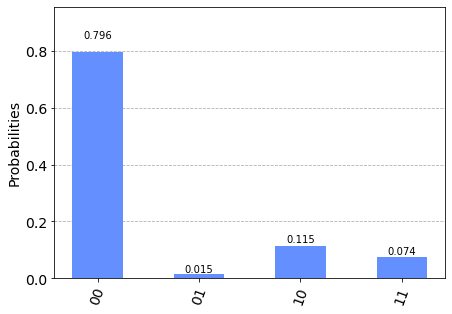

In [5]:
print('The probability distribution after optimizing for 1 iteration')
plot_histogram(Counts[0])


The probability distribution after optimizing for 10 iterations


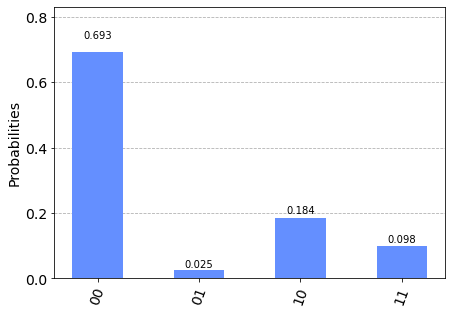

In [6]:
print('The probability distribution after optimizing for 10 iterations')
plot_histogram(Counts[1])

The probability distribution after optimizing for 100 iterations


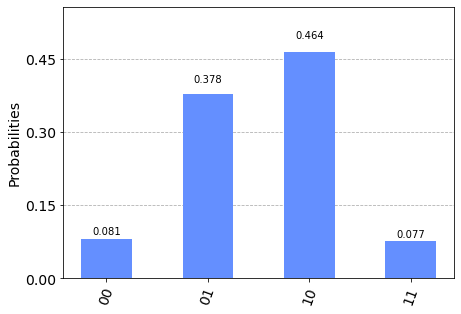

In [7]:
print('The probability distribution after optimizing for 100 iterations')
plot_histogram(Counts[2])

The probability distribution after optimizing for 1000 iterations


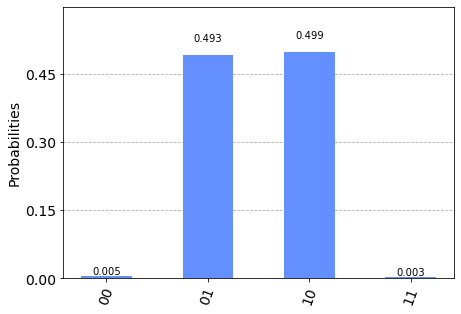

In [8]:
print('The probability distribution after optimizing for 1000 iterations')
plot_histogram(Counts[3])

# 2.4 Reflection

### The pace of convergence:
the pace by which parameters value converges to depends on the learning rate

### The optimum number of iterations:
given this learning rate and a tolerance of 0.01 for angle phi or theta we can say the optimum number of iterations is roughly 450

### Reduced Problem difficulty:
the problem difficulty should have been of 3 or 4 parameters but we had two facts and used them to reduce problem diffculty: 

1- we knew what the vector state is before applying a Cx gate so we saved ourselves the tiresome work of applying a 4x4 matrix on 2 qubit entangled state that is produced after Cx 

2- we knew right before applying a gate on a qubit that it only takes one gate with a certain parameter to produce the state we wanted otherwise we should have applied both an ry and rx gates on both qubit 0 and qubit 1 


### Equivalence between the algorithm and a minimum value problem:

the optimum values are theta= pi/2 and phi= pi which we could have gotten from solving a regular minimum value problem:
\begin{equation} \frac{\partial J_i}{\partial i}=0 \end{equation} specially since each cost function is a function of one variable only.



# 2.5 Implementation with noise

## 2.5.1 Defining a thermal noise function

In [9]:
#setting up initial values for variables
iterations=450
alpha=0.1
theta_initial=0.6
phi_initial =0.7

In [10]:
#introducing a thermal noise model

# T1 and T2 values for qubits 0-3
T1s = np.random.normal(50e3, 10e3, 2) # Sampled from normal distribution mean 50 microsec
T2s = np.random.normal(30e3, 10e3, 2)  # Sampled from normal distribution mean 30 microsec

# Truncate random T2s <= T1s
T2s = np.array([min(T2s[j], 2 * T1s[j]) for j in range(2)])

# Instruction times (in nanoseconds)
time_u1 = 80  # virtual gate
time_cx = 300
time_reset = 1000  # 1 microsecond
time_measure = 1000 # 1 microsecond

# QuantumError objects
errors_reset = [thermal_relaxation_error(t1, t2, time_reset)
                for t1, t2 in zip(T1s, T2s)]
errors_measure = [thermal_relaxation_error(t1, t2, time_measure)
                for t1, t2 in zip(T1s, T2s)]
errors_u1  = [thermal_relaxation_error(t1, t2, time_u1)
              for t1, t2 in zip(T1s, T2s)]
errors_cx = [[thermal_relaxation_error(t1a, t2a, time_cx).expand(
             thermal_relaxation_error(t1b, t2b, time_cx))
              for t1a, t2a in zip(T1s, T2s)]
               for t1b, t2b in zip(T1s, T2s)]

# Add errors to noise model
noise_thermal = NoiseModel()
for j in range(2):
    noise_thermal.add_quantum_error(errors_reset[j], "reset", [j])
    noise_thermal.add_quantum_error(errors_measure[j], "measure", [j])
    noise_thermal.add_quantum_error(errors_u1[j], "u1", [j])
    for k in range(2):
        noise_thermal.add_quantum_error(errors_cx[j][k], "cx", [j, k])

print(noise_thermal)


NoiseModel:
  Basis gates: ['cx', 'id', 'u1', 'u3']
  Instructions with noise: ['reset', 'cx', 'u1', 'measure']
  Qubits with noise: [0, 1]
  Specific qubit errors: [('reset', [0]), ('reset', [1]), ('measure', [0]), ('measure', [1]), ('u1', [0]), ('u1', [1]), ('cx', [0, 0]), ('cx', [0, 1]), ('cx', [1, 0]), ('cx', [1, 1])]


## 2.5.2  code execution 

In [11]:
#Executing with noise model 
noise_model = noise_thermal
basis_gates = noise_model.basis_gates

theta,phi= grad_descent(iterations,theta_initial,phi_initial) #using gradient descent to find optimum theta and phi

#the next section executes the circuit for differnt number of shots

qc1=para_circuit([theta,phi]) #building a circuit using optimum parameters and 1 shot
qc1.measure_all()
results1=execute(qc1,backend,shots=1, basis_gates=basis_gates, noise_model=noise_model).result()
counts1=results1.get_counts()
print(counts1)    

qc10=para_circuit([theta,phi]) #building a circuit using optimum parameters and 10 shots
qc10.measure_all()
results10=execute(qc10,backend,shots=10, basis_gates=basis_gates, noise_model=noise_model).result()
counts10=results10.get_counts()
print(counts10)

qc100=para_circuit([theta,phi]) #building a circuit using optimum parameters and 100 shots
qc100.measure_all()
results100=execute(qc100,backend,shots=100, basis_gates=basis_gates, noise_model=noise_model).result()
counts100=results100.get_counts()
print(counts100)    
    
qc1000=para_circuit([theta,phi]) #building a circuit using optimum parameters and 1000 shots
qc1000.measure_all()
results1000=execute(qc1000,backend,shots=1000, basis_gates=basis_gates, noise_model=noise_model).result()
counts1000=results1000.get_counts()
print(counts1000)    

qc10000=para_circuit([theta,phi]) #building a circuit using optimum parameters and 10000 shots
qc10000.measure_all()
results10000=execute(qc10000,backend,shots=10000, basis_gates=basis_gates, noise_model=noise_model).result()
counts10000=results10000.get_counts()
print(counts10000)    

    

J0 after step 0 is: 0.083784 and theta is: 0.194694 pi,
J1 after step 0 is: 0.381163 phi is :0.231864 pi
J0 after step 1 is: 0.082397 and theta is: 0.198435 pi,
J1 after step 1 is: 0.372629 phi is :0.241115 pi
J0 after step 2 is: 0.080987 and theta is: 0.202207 pi,
J1 after step 2 is: 0.363750 phi is :0.250555 pi
J0 after step 3 is: 0.079556 and theta is: 0.206008 pi,
J1 after step 3 is: 0.354547 phi is :0.260171 pi
J0 after step 4 is: 0.078105 and theta is: 0.209836 pi,
J1 after step 4 is: 0.345048 phi is :0.269946 pi
J0 after step 5 is: 0.076636 and theta is: 0.213689 pi,
J1 after step 5 is: 0.335282 phi is :0.279862 pi
J0 after step 6 is: 0.075149 and theta is: 0.217565 pi,
J1 after step 6 is: 0.325284 phi is :0.289900 pi
J0 after step 7 is: 0.073647 and theta is: 0.221461 pi,
J1 after step 7 is: 0.315092 phi is :0.300041 pi
J0 after step 8 is: 0.072131 and theta is: 0.225376 pi,
J1 after step 8 is: 0.304746 phi is :0.310263 pi
J0 after step 9 is: 0.070603 and theta is: 0.229308 pi,

## 2.5.3 Plotting results for different shots

The probability distribution after optimizing for 1 shot with thermal noise
{'10': 1}


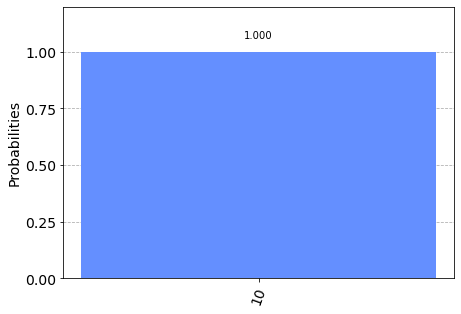

In [12]:
print('The probability distribution after optimizing for 1 shot with thermal noise')
print(counts1)
plot_histogram(counts1)      


The probability distribution after optimizing for 10 shots with thermal noise
{'01': 2, '10': 8}


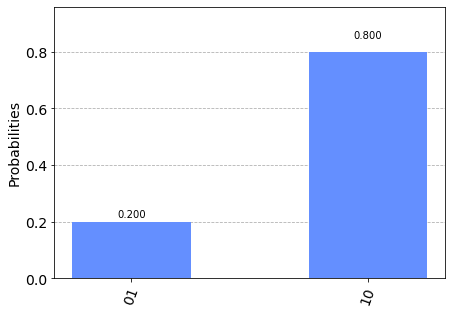

In [13]:
print('The probability distribution after optimizing for 10 shots with thermal noise')
print(counts10)
plot_histogram(counts10)


The probability distribution after optimizing for 100 shots with thermal noise
{'00': 3, '01': 49, '10': 47, '11': 1}


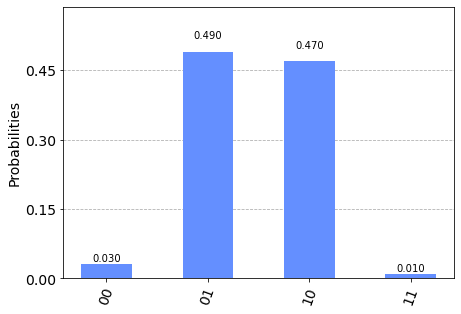

In [14]:
print('The probability distribution after optimizing for 100 shots with thermal noise')
print(counts100)
plot_histogram(counts100)


The probability distribution after optimizing for 1000 shots with thermal noise
{'00': 37, '01': 463, '10': 486, '11': 14}


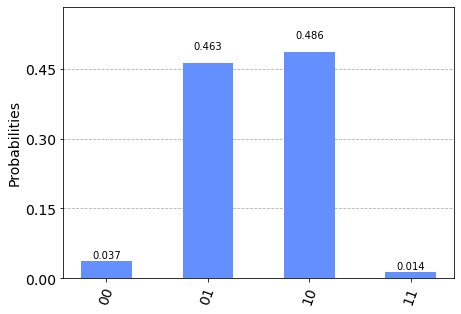

In [15]:
print('The probability distribution after optimizing for 1000 shots with thermal noise')
print(counts1000)
plot_histogram(counts1000)


The probability distribution after optimizing for 10000 shots with thermal noise
{'00': 426, '01': 4720, '10': 4741, '11': 113}


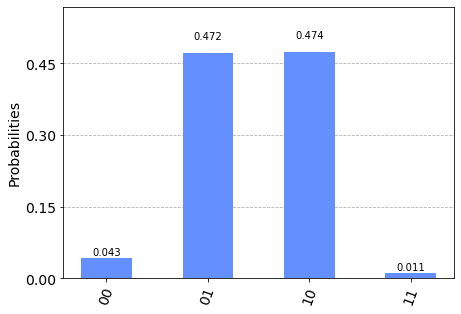

In [16]:
print('The probability distribution after optimizing for 10000 shots with thermal noise')
print(counts10000)
plot_histogram(counts10000)


# 2.6 Reflection:

the observation:increasing number of shots doesn't really affect the ratio of probabilities

hypothesis: we can't really notice a trend unless we execute an enormous number of experiments to find a distribution and then it will be around the |01>+|10> state with small margian for ideal simulator and larger one for noisy simulator